# **Predict celltype-specific sex differences in mouse liver**
In this notebook I use the models trained in the hyperparameter search in order to compare the performance of BuDDI in identifying which genes have the largest celltype-specific sex differences in the mouse liver.

Here I compare against looking at sex-differences using bulk data only. We would expect that the bulk data would capture the differential genes of the most common cell-types, but perform not as well in the less frequent cell types.

We will focus on the results from the PR curve and want to identify the top genes at the top of our DE results lists. Ideally, since bulk is a mix of cell types, BuDDI should be more specific for each cell-type. Bulk will identify the genes, but likely lower on the list.


# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_liver/"

de_genes_path = f"{os.getcwd()}/../data/single_cell_data/liver_sex/de_pseudobulk_results.pkl"
de_bulk_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/de_real_bulk_results.pkl"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-liver"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 51 # 3 "patients", old / young

# number of drugs (one-hot encoded)
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_bulk = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in male first
sample_order = ['30-M-5']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

# now read in female
sample_order = ['18-F-51']
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



30-M-5
18-F-51


<ipython-input-4-87ecae84aa3b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
<ipython-input-4-87ecae84aa3b>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
<ipython-input-4-87ecae84aa3b>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

### format sample indicies and get variable genes

In [5]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6680)[-6680:] # num_genes # 6679
gene_df = gene_df.iloc[idx_top]

union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)


7000

### normalize

In [6]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()
meta_kp = meta_df.iloc[idx_sc_train]


### plot data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3649 samples in 0.014s...
[t-SNE] Computed neighbors for 3649 samples in 0.921s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3649
[t-SNE] Computed conditional probabilities for sample 2000 / 3649
[t-SNE] Computed conditional probabilities for sample 3000 / 3649
[t-SNE] Computed conditional probabilities for sample 3649 / 3649
[t-SNE] Mean sigma: 1.161060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.591805
[t-SNE] KL divergence after 500 iterations: 0.939752
(3649, 2)
(3649, 2)


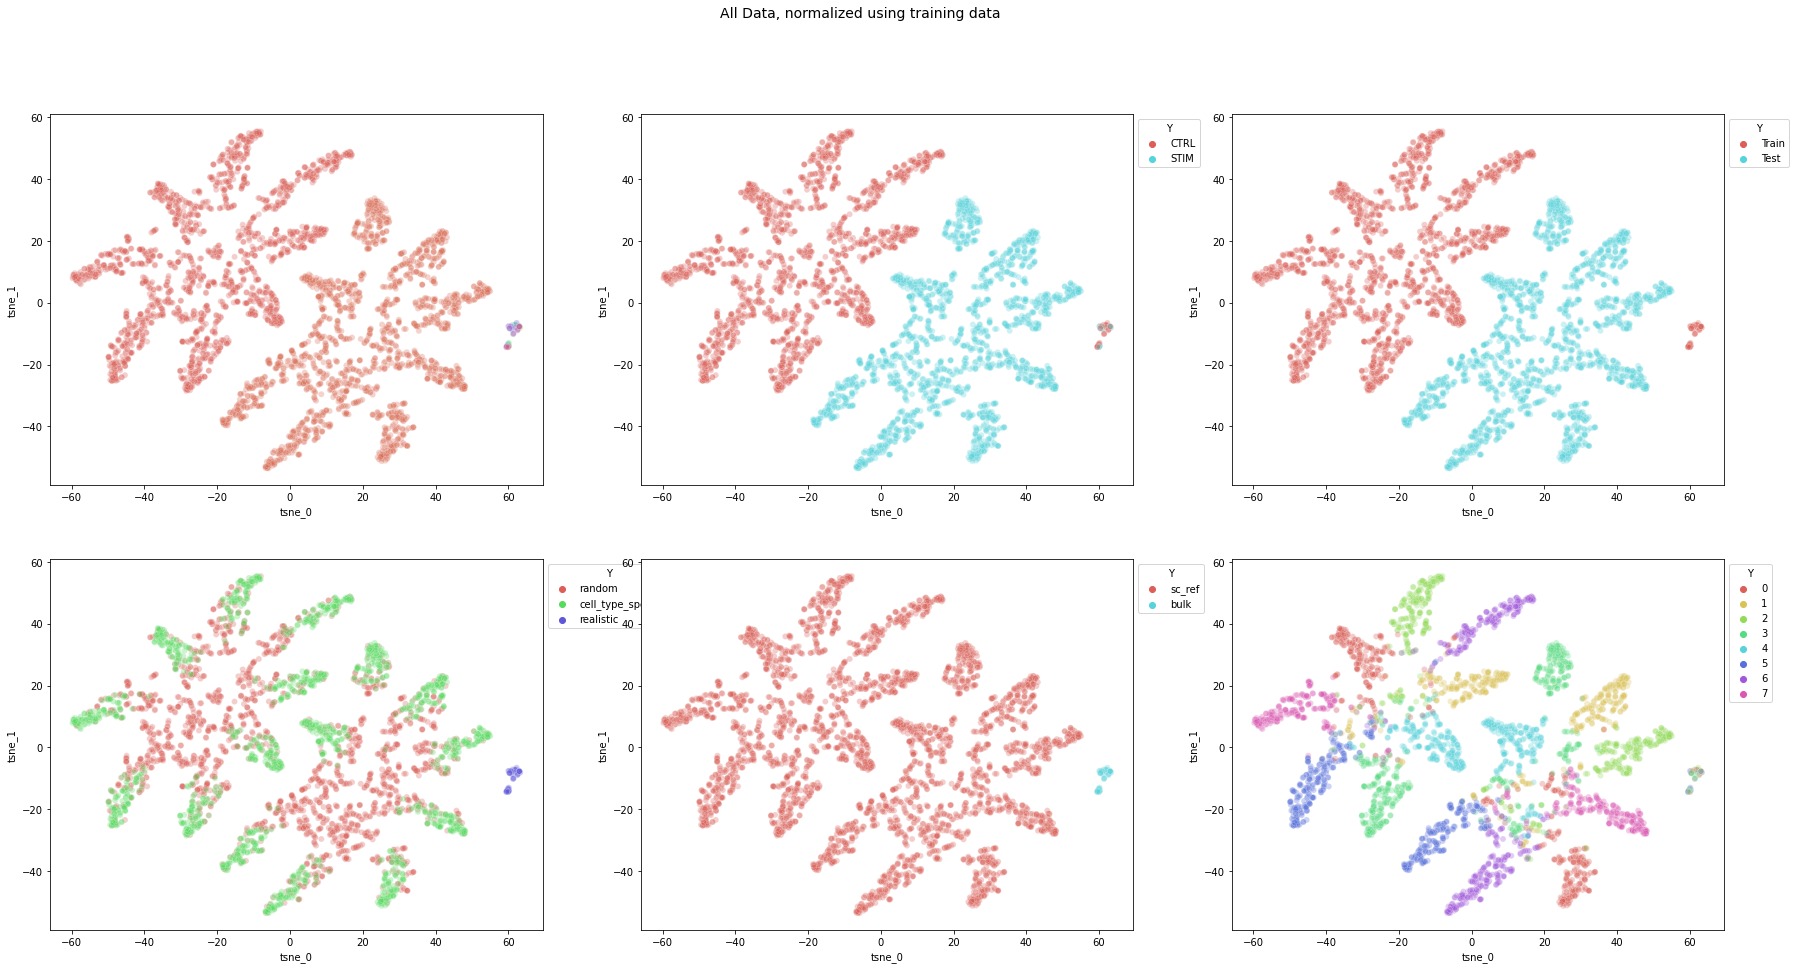

In [7]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(49, 2)
(49, 2)


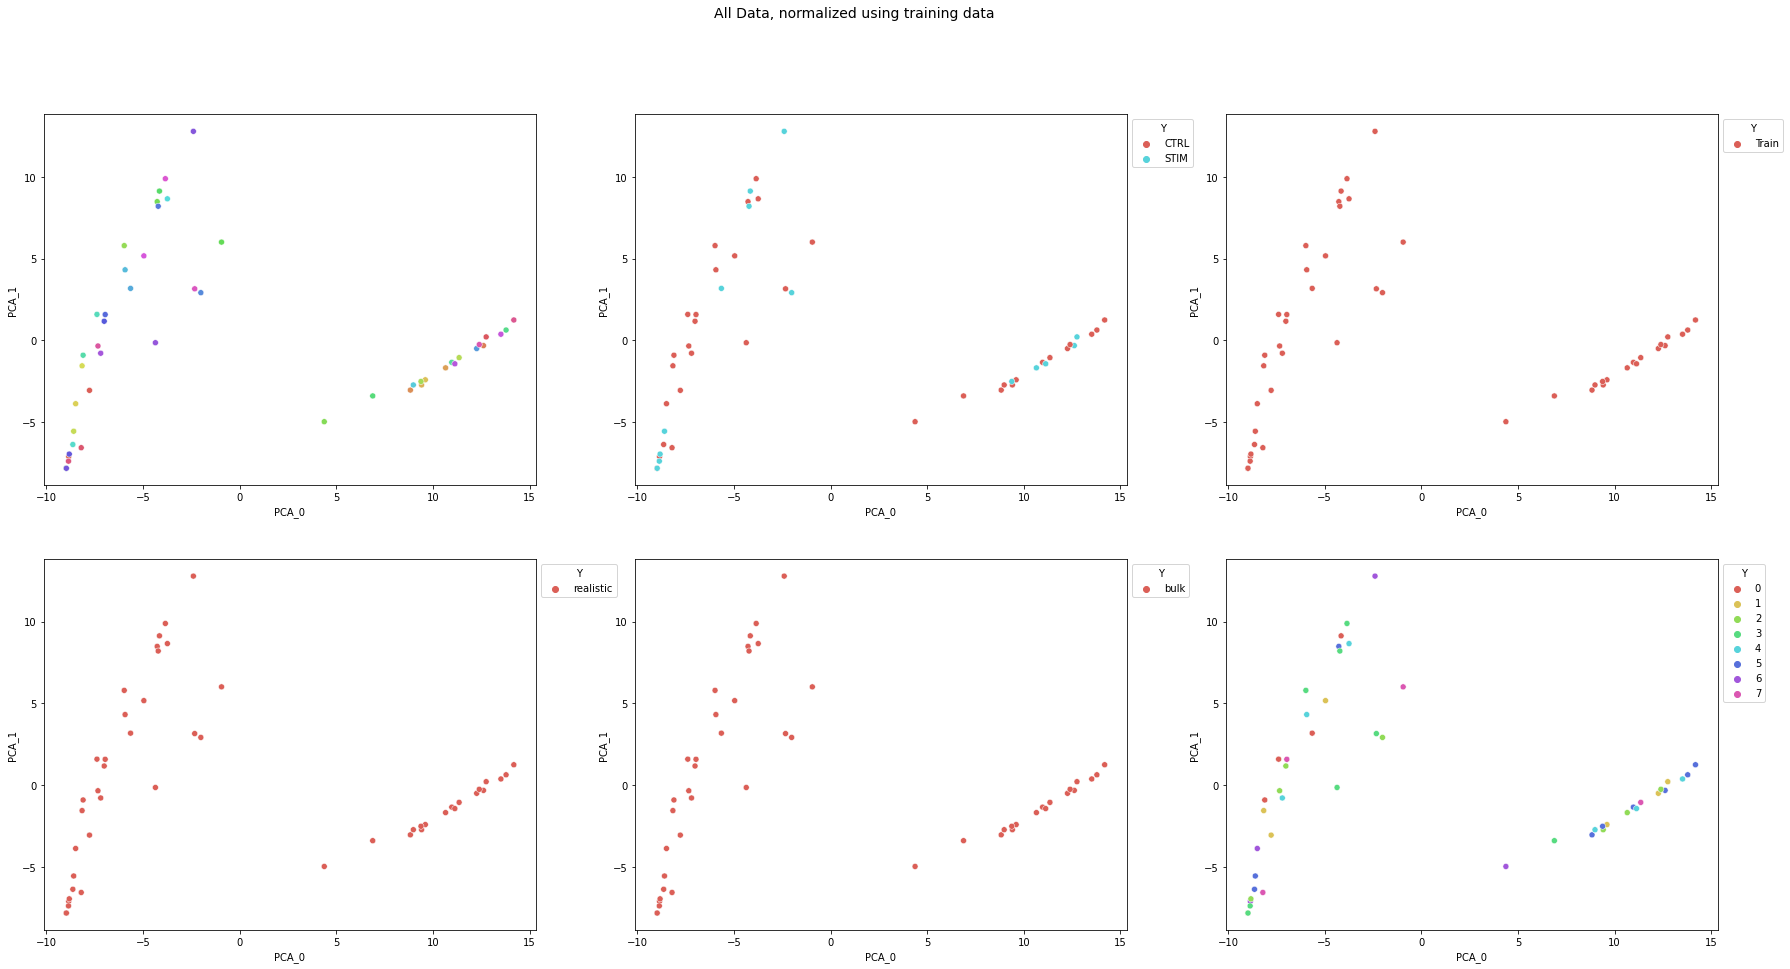

In [8]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1)
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1)


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.000s...
[t-SNE] Computed neighbors for 49 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 8.985739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.821255
[t-SNE] KL divergence after 500 iterations: 0.646444
(49, 2)
(49, 2)


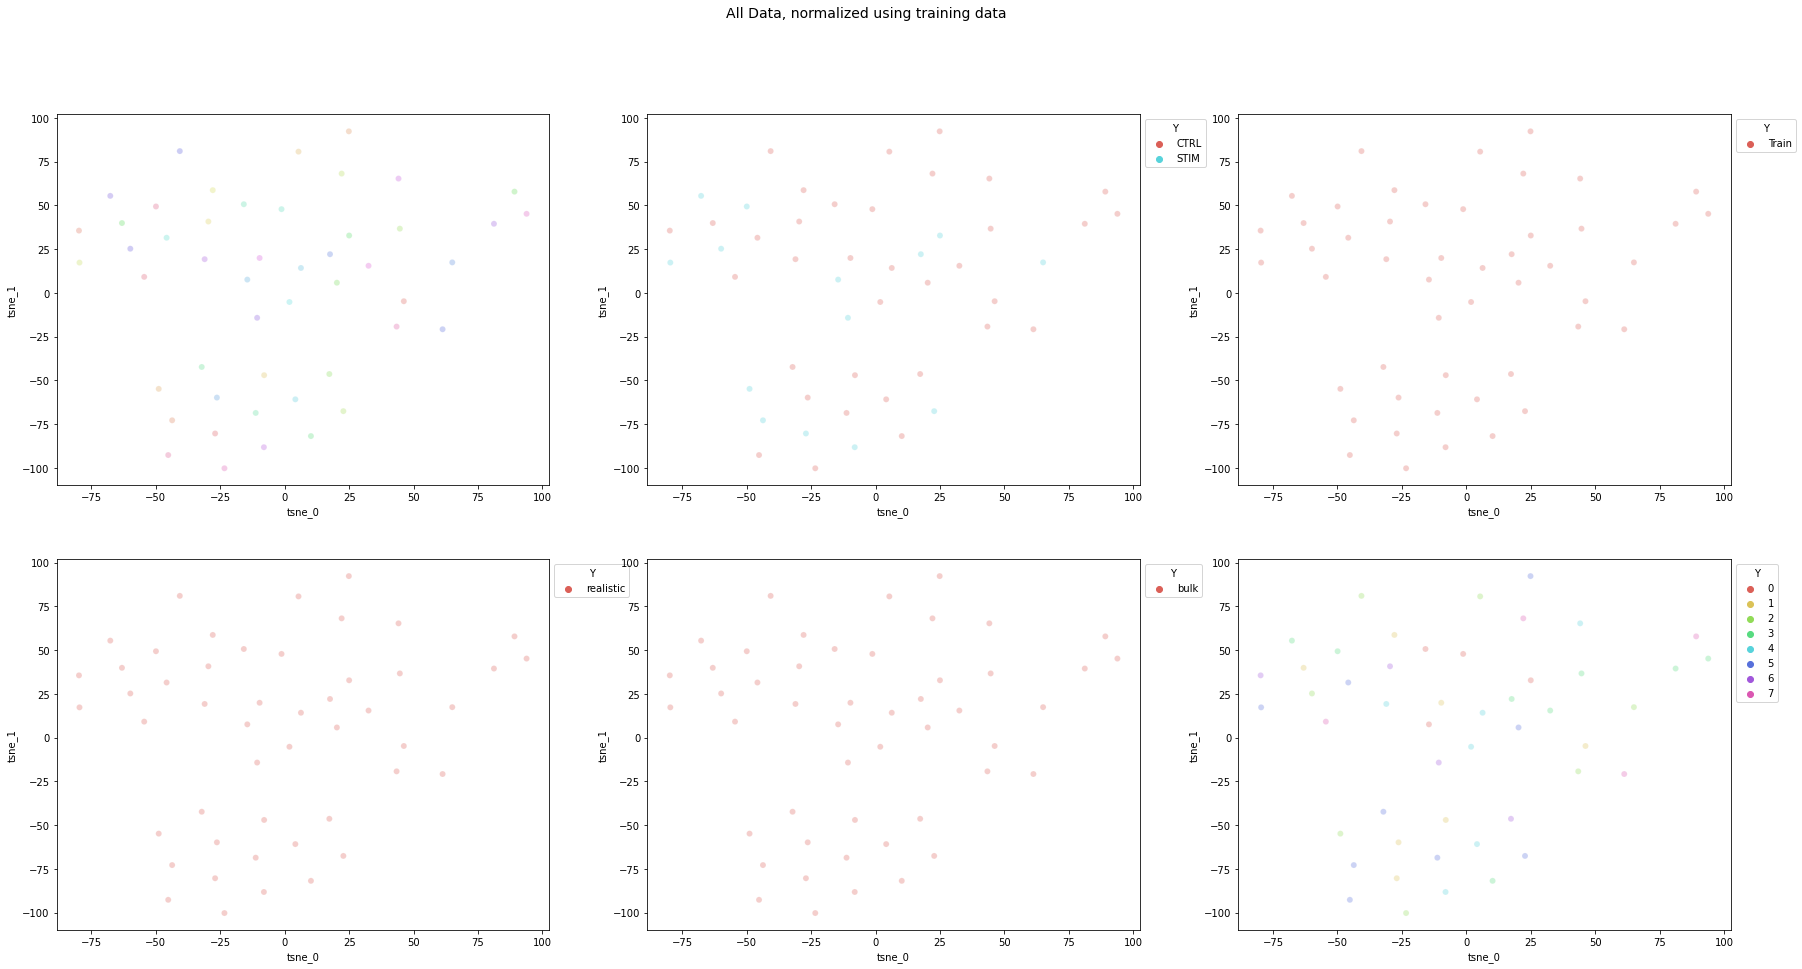

In [9]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [10]:

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_classifier")


res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_classifier")


## Do latent space projectsions

### drug perturbation

In [11]:

res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res2_enc_unlab, res2_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res3_enc_unlab, res3_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../buddi/buddi.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../buddi/buddi.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

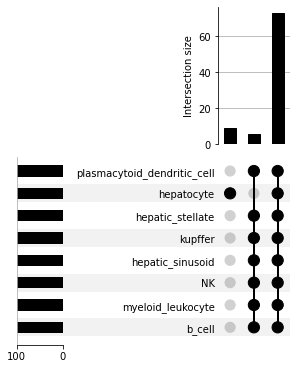

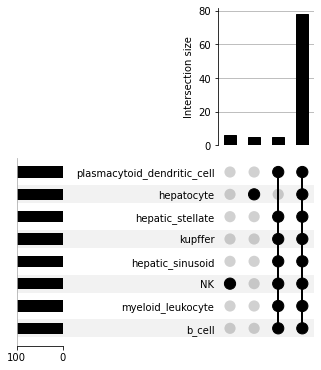

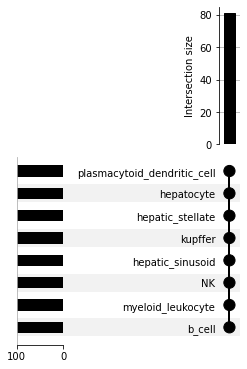

In [12]:
# identify how cell-type specific the DE genes are
cell_diff = from_contents(res1_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res2_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res3_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()


### load the single-nucleus DE results from XX publication

In [13]:
from gene_lists import load_genelists

union_genes_cap, Pub_DE, Pub_DE_immune, Pub_DE_hepatic, Pub_DE_kupffer, Pub_DE_hsc = load_genelists(union_genes)

### load bulk DE results

In [14]:
de_bulk = pickle.load(open( de_bulk_path, "rb" ))
de_bulk.index = [x.upper() for x in de_bulk.index] 
de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
intersect_bulk = np.intersect1d(de_bulk.index.to_list(), union_genes_cap)

bulk_sig_df = pd.DataFrame(union_genes_cap, index=union_genes_cap)
bulk_sig_df["padj"] = 1
padj_val = de_bulk.padj[intersect_bulk]
bulk_sig_df.padj.loc[intersect_bulk] = padj_val

bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

bulk_sig_df["log2FC"] = 1
fc_val = de_bulk.log2FoldChange[intersect_bulk]
bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)

bulk_sig_df

<ipython-input-14-1b0febddcbf6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
<ipython-input-14-1b0febddcbf6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)


,0,padj,log10padj,log2FC
0610005C13RIK,0610005C13RIK,1.0,-0.0,1.0
0610009B22RIK,0610009B22RIK,1.0,-0.0,1.0
0610010F05RIK,0610010F05RIK,1.0,-0.0,1.0
0610012G03RIK,0610012G03RIK,1.0,-0.0,1.0
0610031O16RIK,0610031O16RIK,1.0,-0.0,1.0
...,...,...,...,...
ZXDB,ZXDB,1.0,-0.0,1.0
ZYG11B,ZYG11B,1.0,-0.0,1.0
ZYX,ZYX,1.0,-0.0,1.0
ZZEF1,ZZEF1,1.0,-0.0,1.0


### load single-cell DE genes result

In [15]:
de_genes = pickle.load(open( de_genes_path, "rb" ))
de_genes

{'hepatocyte': ['Rbp4',
  'Rpl37',
  'Serpina1d',
  'Apoc1',
  'Serpina1b',
  'Itih2',
  'Hmgcs2',
  'Rpl36',
  'Mgst1',
  'Gnmt',
  'Rplp1',
  'Rps15',
  'Rpl38',
  'Ttr',
  'Etfa',
  'Ebpl',
  'Pah',
  'Amacr',
  'Ndufa3',
  'Rps8',
  'Cox4i1',
  'Aldh2',
  'Atf5',
  'Rps25',
  'Hamp',
  'Fau',
  'Serpina1a',
  'Rps27a',
  'Rps14',
  'Acaa1b',
  'Ldha',
  'Mup3',
  'Atp5e',
  'Ftcd',
  'Prdx1',
  'Ndufa13',
  'Rpl35',
  'Rpl28',
  'Tst',
  'Atp5g3',
  'Fah',
  'Rpl8',
  'Rpl13a',
  'Rps3a',
  'Slc25a3',
  'Uqcrq',
  'Fbp1',
  'Rpl14',
  'Ttc36',
  'Atp5b',
  'Hebp1',
  'Rps12',
  'Otc',
  'Eef1a1',
  'Rps24',
  'Gchfr',
  'Ccbl2',
  'Ftl1',
  'Atp5a1',
  'Igfbp4',
  'Rps18',
  'Hspd1',
  'Ndufv3',
  'Ran',
  'Gstt1',
  'Rps4x',
  'Dpyd',
  'Etfb',
  'Serpina1c',
  'Sod1',
  'Rpl13',
  'Gstz1',
  'Hsd11b1',
  'Rpl23',
  'Chchd2',
  'Hgd',
  'Ndufc2',
  'Acad11',
  'Ndufa6',
  'Got2',
  'Uqcr11',
  'Rpl7a',
  'Ctsh',
  'Pgls',
  'Spr',
  'Tmem93',
  'Dak',
  'Rpl9',
  'Khk',
  'Hmgcs1'

In [41]:
from matplotlib_venn import venn3
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve
from random import sample

sns.set_palette("Set2")

# get PR curve

def plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, de_bulk_genes, curr_cell_type, sn_DE_ref, sn_sc_DE_ref, axs, union_genes_cap):

    # this is for the "projected" expression
    curr_idx = np.where(ctrl_test_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization
    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)

    # make dataframe of true/false positives
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes_cap)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    # make a random one
    proj_log2FC_df["random"] = sample(proj_log2FC_df[0].tolist(), len(proj_log2FC_df[0].tolist()))

    # compare with bulk alone
    proj_log2FC_df["bulk"] = de_bulk_genes.log2FC.loc[union_genes_cap]

    proj_log2FC_df["sn_DE"] = 0
    proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1

    proj_log2FC_df["sc_sn_DE"] = 0
    proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1



    # now do the single-nucleus cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sn_DE, proj_log2FC_df[0], name="BuDDI", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sn_DE, proj_log2FC_df[0], name="BuDDI", ax=axs[0,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sn_DE, proj_log2FC_df.random, name="random",ax= axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sn_DE, proj_log2FC_df.random, name="random", ax=axs[0,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sn_DE, proj_log2FC_df.bulk, name="bulk",ax= axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sn_DE, proj_log2FC_df.bulk, name="bulk", ax=axs[0,1])


    # now do the single-nucleus cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sc_sn_DE, proj_log2FC_df[0], name="BuDDI", ax=axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sc_sn_DE, proj_log2FC_df[0], name="BuDDI", ax=axs[1,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sc_sn_DE, proj_log2FC_df.random, name="random",ax= axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sc_sn_DE, proj_log2FC_df.random, name="random", ax=axs[1,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sc_sn_DE, proj_log2FC_df.bulk, name="bulk",ax= axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sc_sn_DE, proj_log2FC_df.bulk, name="bulk", ax=axs[1,1])

    sn_avg_pr_BuDDI = average_precision_score(proj_log2FC_df.sn_DE, proj_log2FC_df[0])
    sn_avg_pr_random = average_precision_score(proj_log2FC_df.sn_DE, proj_log2FC_df.random)
    sn_avg_pr_bulk = average_precision_score(proj_log2FC_df.sn_DE, proj_log2FC_df.bulk)

    sc_sn_avg_pr_BuDDI = average_precision_score(proj_log2FC_df.sc_sn_DE, proj_log2FC_df[0])
    sc_sn_avg_pr_random = average_precision_score(proj_log2FC_df.sc_sn_DE, proj_log2FC_df.random)
    sc_sn_avg_pr_bulk = average_precision_score(proj_log2FC_df.sc_sn_DE, proj_log2FC_df.bulk)

    res_df = pd.DataFrame([sn_avg_pr_BuDDI, sn_avg_pr_random, sn_avg_pr_bulk,
                                  sc_sn_avg_pr_BuDDI, sc_sn_avg_pr_random, sc_sn_avg_pr_bulk])
    res_df.columns = ["scores"]
    res_df["metric"] = ["avg_pr"]*6
    res_df["cell_type"] = [curr_cell_type]*6
    res_df["ref_set"] = ["sn"]*3+["sc_sn"]*3
    res_df["method"] = ["BuDDI", "random", "bulk"]*2

    return axs, proj_log2FC_df, res_df


In [17]:
min_overlap = 50

In [49]:
de_genes.keys()

dict_keys(['hepatocyte', 'hepatic_sinusoid', 'kupffer', 'hepatic_stellate', 'NK', 'plasmacytoid_dendritic_cell', 'b_cell', 'myeloid_leukocyte'])

hepatocyte


<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin

hepatic_sinusoid


<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin

kupffer


<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin

hepatic_stellate


<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin

NK


<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin

b_cell


<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin(union_genes_cap, sn_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_sn_DE[np.where(np.isin(union_genes_cap, sn_sc_DE_ref))[0]] = 1
<ipython-input-41-7784ed058be3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sn_DE[np.where(np.isin

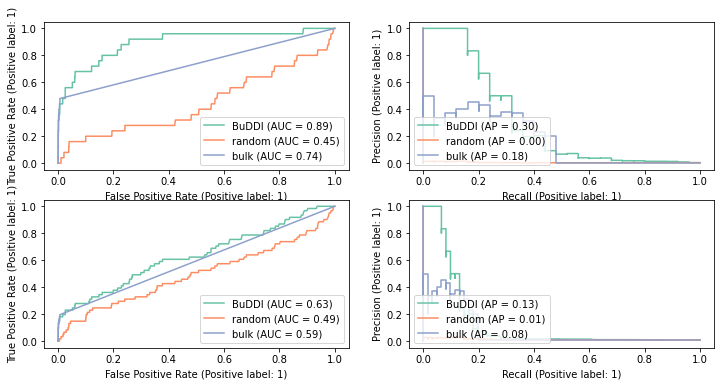

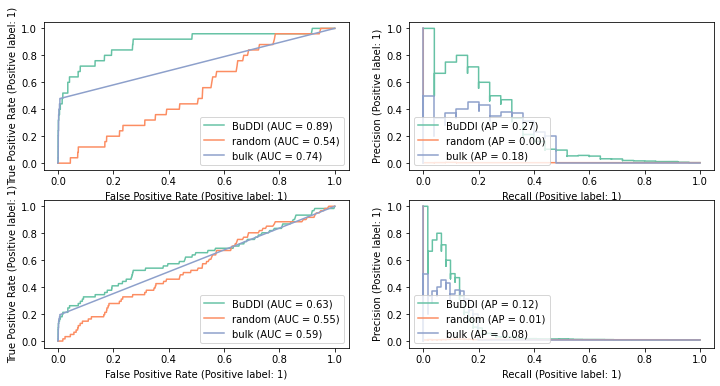

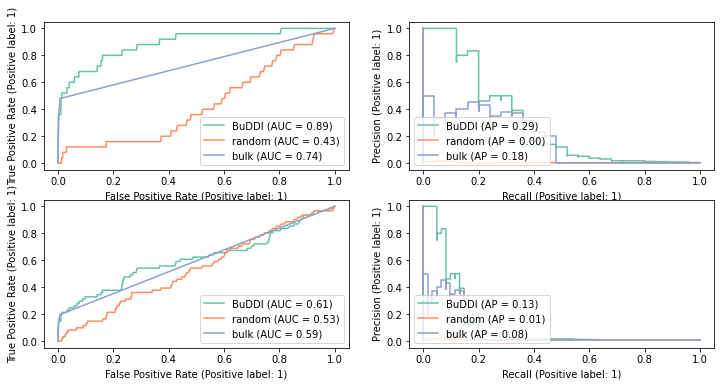

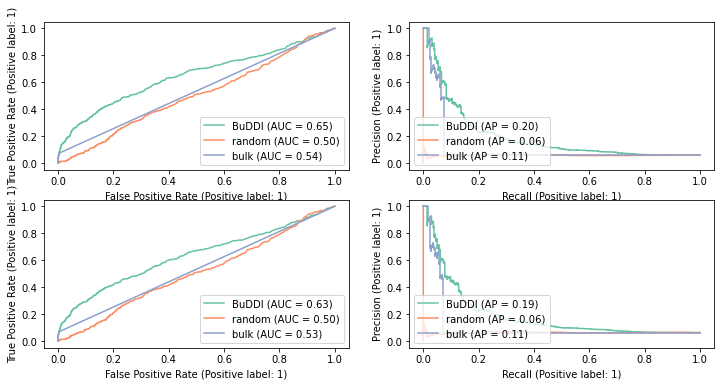

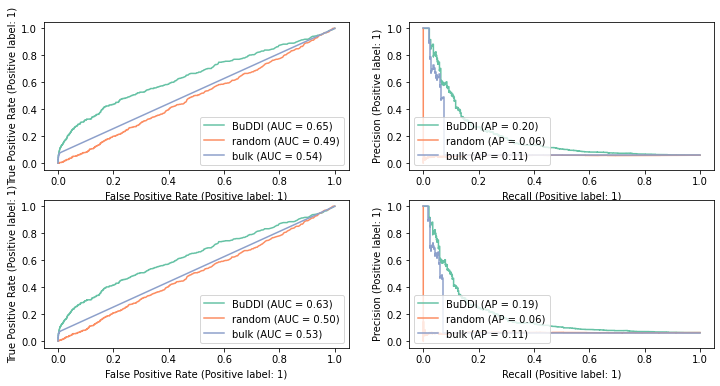

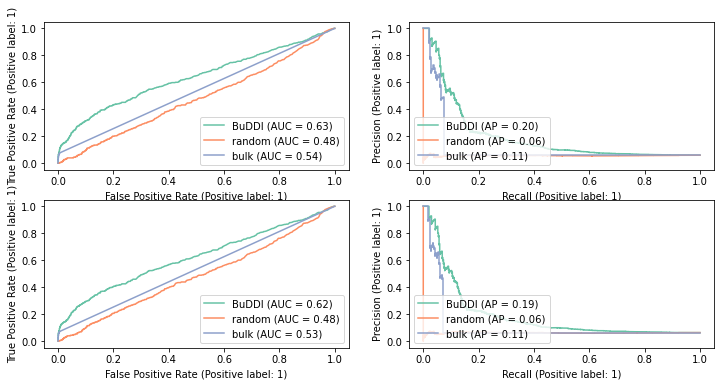

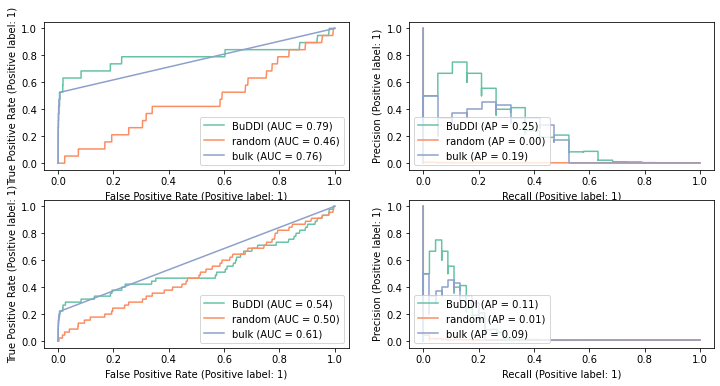

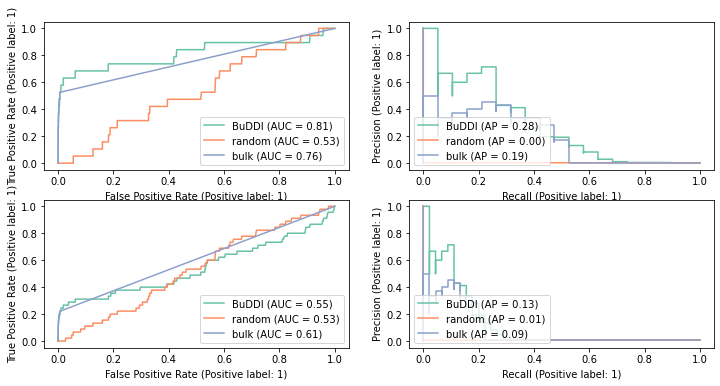

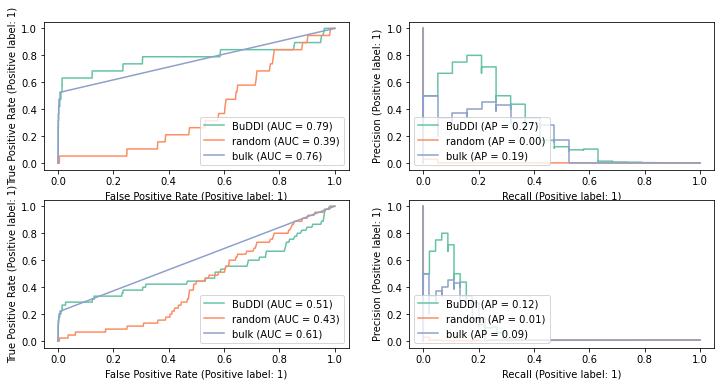

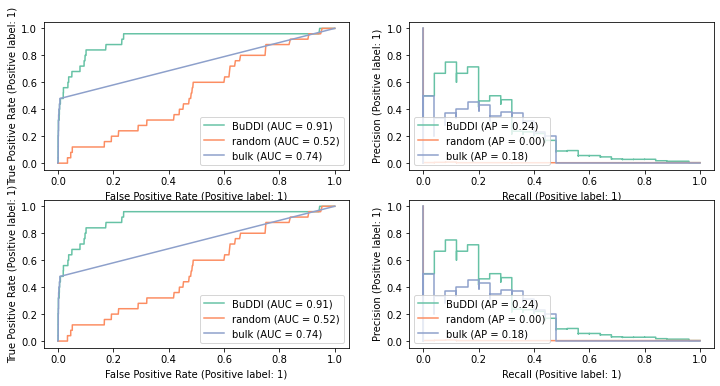

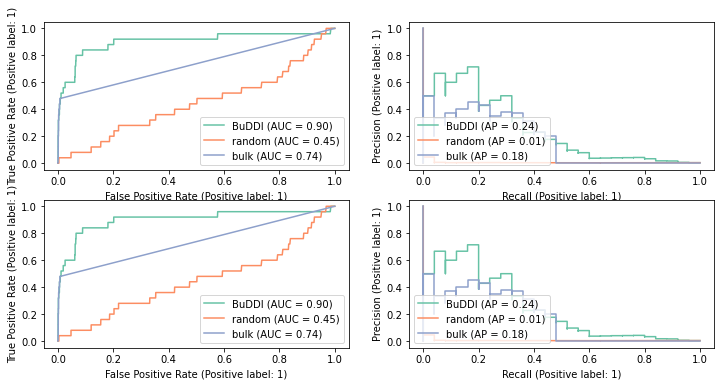

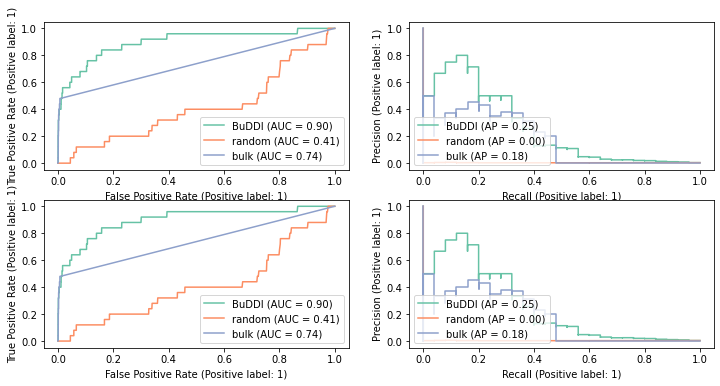

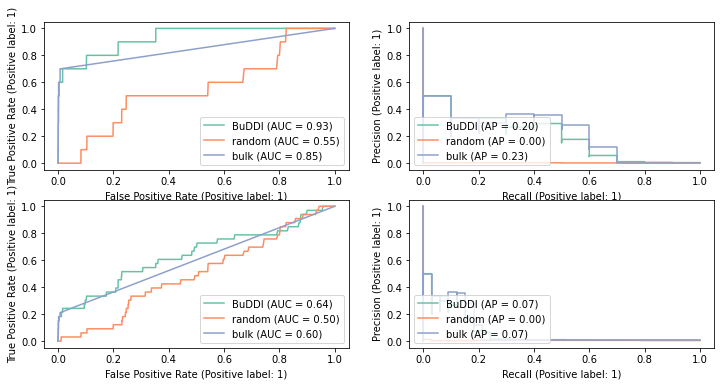

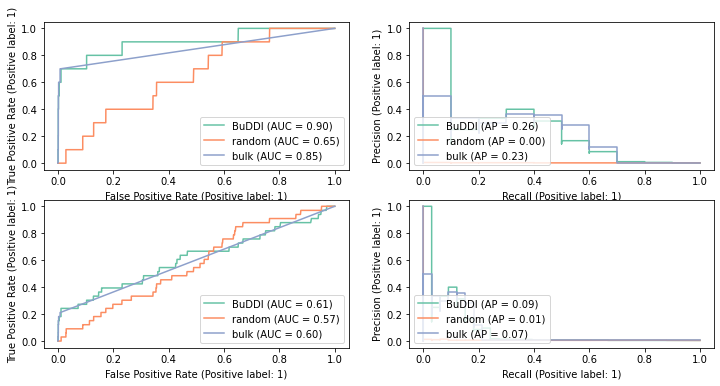

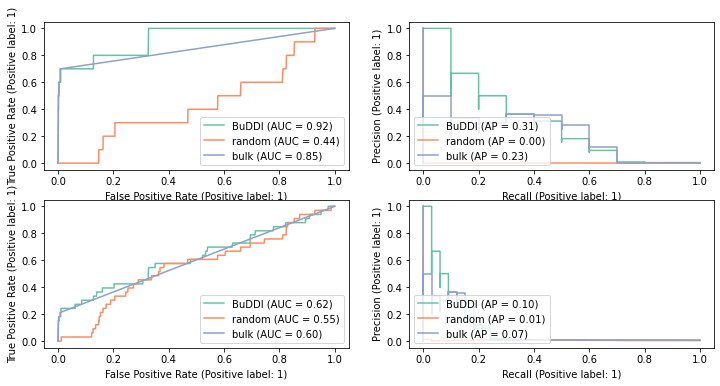

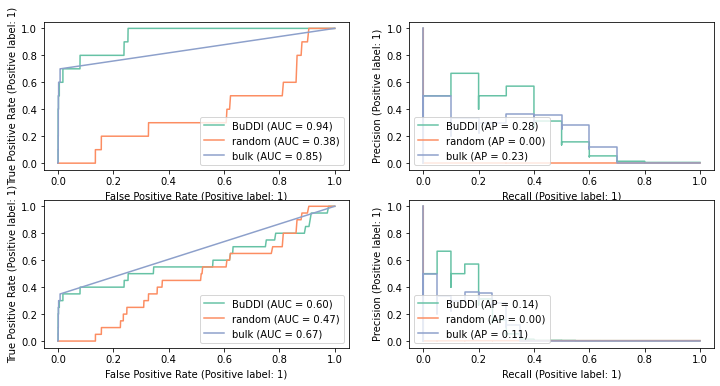

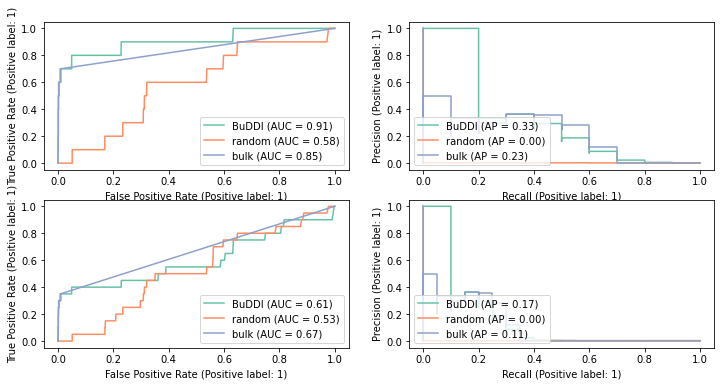

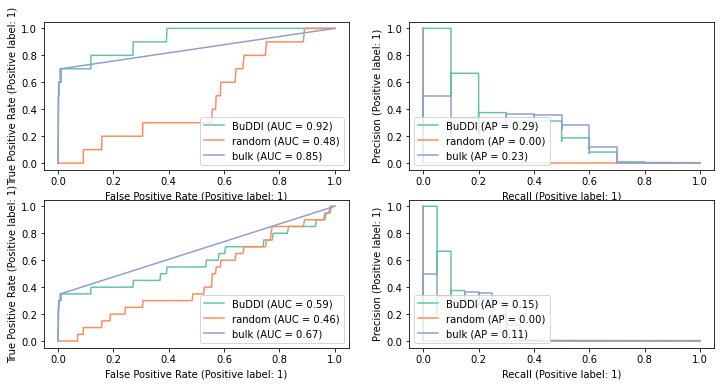

In [59]:

# get PR curve

curr_cell_type = "hepatocyte"
all_cell_types = ["hepatocyte", "hepatic_sinusoid", "kupffer",
                  "hepatic_stellate", "NK", "b_cell"]
all_DE_ref = [Pub_DE_hsc, Pub_DE_hepatic, Pub_DE_kupffer, 
              Pub_DE_hsc, Pub_DE_immune, Pub_DE_immune]


all_res_df = None
curr_idx = 0
for curr_cell_type in all_cell_types:

    print(curr_cell_type)

    # get our DE genes
    de_genes_curr = de_genes[curr_cell_type]
    if de_genes_curr is not None:
        de_genes_curr = [x.upper() for x in de_genes_curr]


    # get bulk DE genes

    # set the reference genes
    DE_ref = Pub_DE
    ct_DE_ref = all_DE_ref[curr_idx]
    extra_ref = ct_DE_ref
    if de_genes_curr is not None:
        extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = plot_PR_ROC(res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap)

    res_df["run_id"] = 1
    all_res_df = pd.concat([all_res_df, res_df])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = plot_PR_ROC(res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap)

    res_df["run_id"] = 2
    all_res_df = pd.concat([all_res_df, res_df])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = plot_PR_ROC(res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap)

    res_df["run_id"] = 3
    all_res_df = pd.concat([all_res_df, res_df])
    

    curr_idx = curr_idx + 1


In [60]:
all_res_df

,scores,metric,cell_type,ref_set,method,run_id
0,0.303930,avg_pr,hepatocyte,sn,BuDDI,1
1,0.004961,avg_pr,hepatocyte,sn,random,1
2,0.175556,avg_pr,hepatocyte,sn,bulk,1
3,0.132158,avg_pr,hepatocyte,sc_sn,BuDDI,1
4,0.012055,avg_pr,hepatocyte,sc_sn,random,1
...,...,...,...,...,...,...
1,0.001506,avg_pr,b_cell,sn,random,3
2,0.226276,avg_pr,b_cell,sn,bulk,3
3,0.149036,avg_pr,b_cell,sc_sn,BuDDI,3
4,0.002752,avg_pr,b_cell,sc_sn,random,3


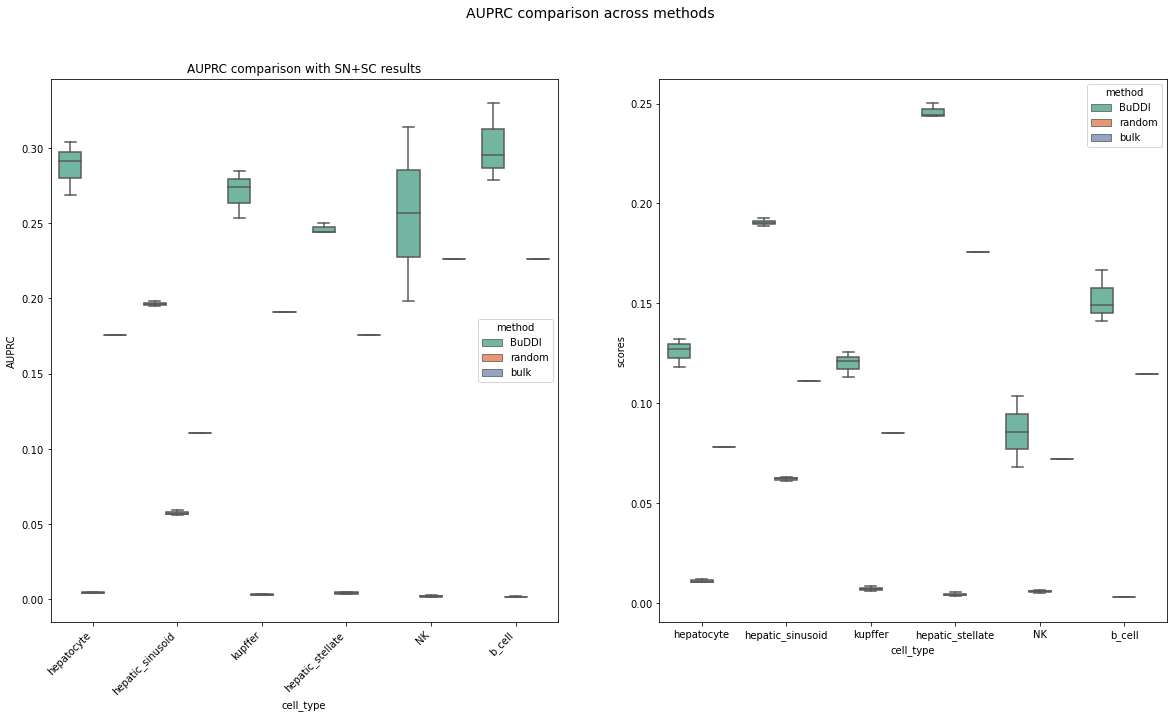

In [62]:

# plot
fig, axs = plt.subplots(1, 2, figsize=(20,10))

sns.boxplot(data=all_res_df[all_res_df["ref_set"] == "sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[0])
axs[0].set_title("AUPRC comparison with SN results")
axs[0].set(ylabel="AUPRC")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.boxplot(data=all_res_df[all_res_df["ref_set"] == "sc_sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[1])
axs[0].set_title("AUPRC comparison with SN+SC results")
axs[0].set(ylabel="AUPRC")
axs[0].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle("AUPRC comparison across methods", fontsize=14)

fig.show()

